# FIGS 2H & 3B

*Marcos Martinez Jimenez*

---

Script used to obtain figures 2H and 3B from Networld's PNAS. Basic check that the model retains desirable properties after being modified.

**Input**: processed networld simulation data

## Setup

***Module Import***

In [1]:
import os
import matplotlib.pyplot as plt

from scipy.stats import entropy

from matlab_utils import *
import plotly.express as px


***Global Metadata***

In [2]:
networks, measures = load_meta_networld()


***Data loading***

In [3]:
# Path where all SRC files are included
data_path = '../data/Networld_N40_TMax5000_Kinetics_Binomial_K0.01/'

nt_list = []
for data_file in os.listdir(data_path):
    info = data_file[:-4].split('_')
    if info[0] != 'SRC':
        continue
    beta = info[2][4:]
    rep = info[4][3:]
    data_file = data_path + data_file
    src = load_src_networld(data_file)
    src['beta'] = float(beta)
    src['rep'] = int(rep)
    nt_list.append(src)


For this figures the abundance of networks for each $\beta$ is enough

In [4]:
exp_data = pd.concat(nt_list, axis=0)
exp_data = exp_data.sort_values(by=['beta', 'rep', 'NRed'])
exp_data = exp_data.groupby(['beta', 'NRed'])['NRep'].sum().reset_index()
exp_data['NRep'] = exp_data['NRep'] / \
    exp_data.groupby('beta')['NRep'].transform(sum)
exp_data.head()


,beta,NRed,NRep
0,0.000000,0.0,1.000000
1,0.010000,0.0,0.999911
2,0.010000,1.0,0.000089
3,0.031623,0.0,0.999682
4,0.031623,1.0,0.000317


## Compute metrics

***# Configurations***

In [5]:
# Number of different network identifiers by beta
num_configs = exp_data.groupby('beta')['NRed'].nunique().reset_index()
num_configs.head()


,beta,NRed
0,0.000000,1
1,0.010000,2
2,0.031623,3
3,0.100000,3
4,0.200000,3


***Normalized H***

In [6]:
normH = exp_data.groupby('beta')['NRep'].aggregate(entropy).reset_index()
normH['NRep'] = normH['NRep'] / np.log2(num_configs['NRed'])
# For beta=0 only one network -> NA value, but should be a 0
normH = normH.fillna(0)
normH.head()


,beta,NRep
0,0.000000,0.000000
1,0.010000,0.000919
2,0.031623,0.001821
3,0.100000,0.005124
4,0.200000,0.009896


## Transition Limits

In [7]:
def pnas_2h_3b(num_configs, normH, logx=False, xlims=[0, 3]):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 3))

    ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
    ax1.set_title('2H')
    ax1.set_xlabel(r'$\beta$')
    ax1.set_ylabel('# Configurations')
    ax1.set_yscale('log')
    if logx:
        ax1.set_xscale('log')
    ax1.set_xlim(xlims[0], xlims[1])
    ax1.grid(which='both', axis='x')
    ax1.grid(which='major', axis='y')

    ax2.plot(normH['beta'], normH['NRep'], 'o')
    ax2.set_title('3B')
    ax2.set_xlabel(r'$\beta$')
    ax2.set_ylabel('Normalized H')
    if logx:
        ax2.set_xscale('log')
    ax2.set_xlim(xlims[0], xlims[1])
    ax2.grid(which='both', axis='x')
    ax2.grid(which='major', axis='y')

    fig.tight_layout()
    fig.show()


Inspect the graphs to identify prospective transition bounds

In [35]:
px.scatter(normH, x='beta', y='NRep',
           log_x=True, log_y=False,
           title='3B', labels=dict(beta='β', NRep='Norm H'))


/tmp/ipykernel_26308/1901035473.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


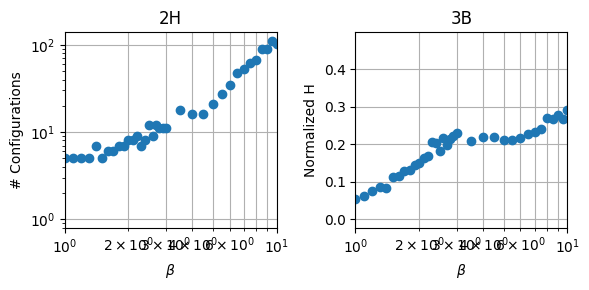

In [18]:
pnas_2h_3b(num_configs, normH, logx=True, xlims=[1, 10])


/tmp/ipykernel_18314/1901035473.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


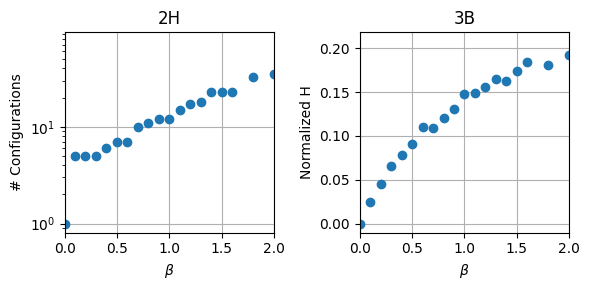

In [11]:
pnas_2h_3b(num_configs, normH, xlims=[0, 2])


/tmp/ipykernel_6519/1901035473.py:26: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



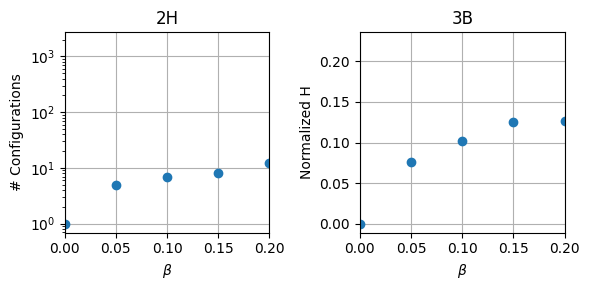

In [27]:
pnas_2h_3b(num_configs, normH, xlims=[0, 0.2])


***Transition Bounds***

In [56]:
# 1st value is critic beta and 2nd is the change of behaviour
# caused by network colapse and node limitation
beta_lims = (0.55, 1.1)


In [57]:
pre_idx = (num_configs['beta'] < beta_lims[0]) \
    & (num_configs['beta'] > 0)
pos_idx = (num_configs['beta'] >= beta_lims[0]) \
    & (num_configs['beta'] < beta_lims[1])

p_nc_pre = np.polyfit(num_configs.loc[pre_idx, 'beta'],
                      np.log(num_configs.loc[pre_idx, 'NRed']), 1)
p_nc_pos = np.polyfit(num_configs.loc[pos_idx, 'beta'],
                      np.log(num_configs.loc[pos_idx, 'NRed']), 1)
p_nH_pre = np.polyfit(normH.loc[pre_idx, 'beta'],
                      normH.loc[pre_idx, 'NRep'], 1)
p_nH_pos = np.polyfit(normH.loc[pos_idx, 'beta'],
                      normH.loc[pos_idx, 'NRep'], 1)


In [58]:
pre_beta_lr = np.array([0.01, beta_lims[0]])
pos_beta_lr = np.array([beta_lims[0], beta_lims[1]])

pre_nc_lr = np.exp(pre_beta_lr * p_nc_pre[0] + p_nc_pre[1])
pos_nc_lr = np.exp(pos_beta_lr * p_nc_pos[0] + p_nc_pos[1])

pre_nH_lr = pre_beta_lr * p_nH_pre[0] + p_nH_pre[1]
pos_nH_lr = pos_beta_lr * p_nH_pos[0] + p_nH_pos[1]

nc_lr_intersect = (p_nc_pre[1] - p_nc_pos[1]) / (p_nc_pos[0] - p_nc_pre[0])
nH_lr_intersect = (p_nH_pre[1] - p_nH_pos[1]) / (p_nH_pos[0] - p_nH_pre[0])


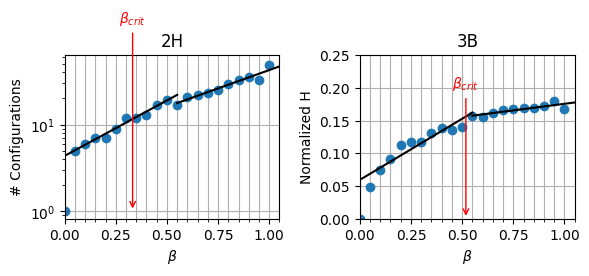

In [59]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 3))

ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
ax1.plot(pre_beta_lr, pre_nc_lr, '-', color='black')
ax1.plot(pos_beta_lr, pos_nc_lr, '-', color='black')
ax1.annotate(r'$\beta_{crit}$', xy=(nc_lr_intersect, 1),
             xytext=(nc_lr_intersect, 150),
             horizontalalignment='center',
             color='red',
             arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax1.set_title('2H')
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('# Configurations')
ax1.set_yscale('log')
ax1.set_xlim(0, 1)
ax1.set_xticks(np.arange(0, 1.1, 0.05), minor=True)
ax1.grid(which='both', axis='x')
ax1.grid(which='major', axis='y')

ax2.plot(normH['beta'], normH['NRep'], 'o')
ax2.plot(pre_beta_lr, pre_nH_lr, '-', color='black')
ax2.plot(pos_beta_lr, pos_nH_lr, '-', color='black')
ax2.annotate(r'$\beta_{crit}$', xy=(nH_lr_intersect, 0),
             xytext=(nH_lr_intersect, 0.2),
             horizontalalignment='center',
             color='red',
             arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax2.set_title('3B')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('Normalized H')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.25)
ax2.set_xticks(np.arange(0, 1.1, 0.05), minor=True)
ax2.grid(which='both', axis='x')
ax2.grid(which='major', axis='y')

fig.tight_layout()


In [36]:
tmp_data = pd.concat(nt_list, axis=0)
tmp_data = tmp_data.sort_values(by=['beta', 'rep', 'NRed'])
tmp_data = tmp_data.groupby(['beta', 'rep', 't'])['NRep'].sum().reset_index()
tmp_data = tmp_data.groupby(['beta'])['NRep'].mean().reset_index()
tmp_data.head(5)


,beta,NRep
0,0.000000,40.000000
1,0.010000,39.996441
2,0.031623,39.987243
3,0.100000,39.958808
4,0.200000,39.912058


<Figure size 600x400 with 0 Axes>

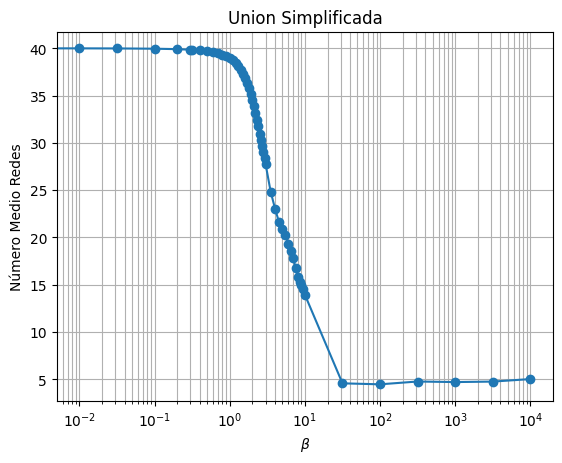

In [37]:
plt.figure(figsize=(6, 4))
tmp_data.plot(x='beta', y='NRep', style='-o', legend=False)
plt.xlabel(r'$\beta$')
plt.ylabel('Número Medio Redes')
plt.xscale('log')
plt.title('Union Simplificada')
# plt.xticks(np.arange(01.1,0.05))
plt.grid(which='both')


In [38]:
px.scatter(tmp_data, x='beta', y='NRep',
           log_x=True, log_y=False,
           title='Número medio redes', labels=dict(beta='β', NRep='Mean N(R)'))
